# 第8章 分类：决策树&朴素贝叶斯，流失预警模型

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pydotplus


In [4]:
churn = pd.read_csv(r'D:\dataset\DM\telecom_churn.csv', skipinitialspace=True)
churn = churn.dropna(axis=0, how='any')
churn.head()

,subscriberID,churn,gender,AGE,edu_class,incomeCode,duration,feton,peakMinAv,peakMinDiff,posTrend,negTrend,nrProm,prom,curPlan,avgplan,planChange,posPlanChange,negPlanChange,call_10086
0,19164958.0,1.0,0.0,20.0,2.0,12.0,16.0,0.0,113.666667,-8.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,39244924.0,1.0,1.0,20.0,0.0,21.0,5.0,0.0,274.000000,-371.0,0.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,0.0,1.0
2,39578413.0,1.0,0.0,11.0,1.0,47.0,3.0,0.0,392.000000,-784.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0
3,40992265.0,1.0,0.0,43.0,0.0,4.0,12.0,0.0,31.000000,-76.0,0.0,1.0,2.0,1.0,3.0,3.0,0.0,0.0,0.0,1.0
4,43061957.0,1.0,1.0,60.0,0.0,9.0,14.0,0.0,129.333333,-334.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0


In [5]:
target = churn['churn']
data = churn.loc[:, 'gender':'call_10086']
data.head()

,gender,AGE,edu_class,incomeCode,duration,feton,peakMinAv,peakMinDiff,posTrend,negTrend,nrProm,prom,curPlan,avgplan,planChange,posPlanChange,negPlanChange,call_10086
0,0.0,20.0,2.0,12.0,16.0,0.0,113.666667,-8.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,20.0,0.0,21.0,5.0,0.0,274.000000,-371.0,0.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,0.0,1.0
2,0.0,11.0,1.0,47.0,3.0,0.0,392.000000,-784.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0
3,0.0,43.0,0.0,4.0,12.0,0.0,31.000000,-76.0,0.0,1.0,2.0,1.0,3.0,3.0,0.0,0.0,0.0,1.0
4,1.0,60.0,0.0,9.0,14.0,0.0,129.333333,-334.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0


In [6]:
import sklearn.cross_validation as cross_validation

train_data, test_data, train_target, test_target = cross_validation.train_test_split(
    data, target, test_size=0.4, train_size=0.6, random_state=42)   #划分训练集和测试集

## CART算法(分类树)
建立CART模型

In [7]:
import sklearn.tree as tree

#lf = tree.DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=100, min_samples_leaf=100, random_state=12345)  
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=100, min_samples_leaf=100, random_state=12345)
#min_samples_split:int,float,可选（默认为2） 区分一个内部节点需要的最少的样本数
# 当前支持计算信息增益和GINI
#clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5, oob_score=True)
clf.fit(train_data, train_target)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=100,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=12345, splitter='best')

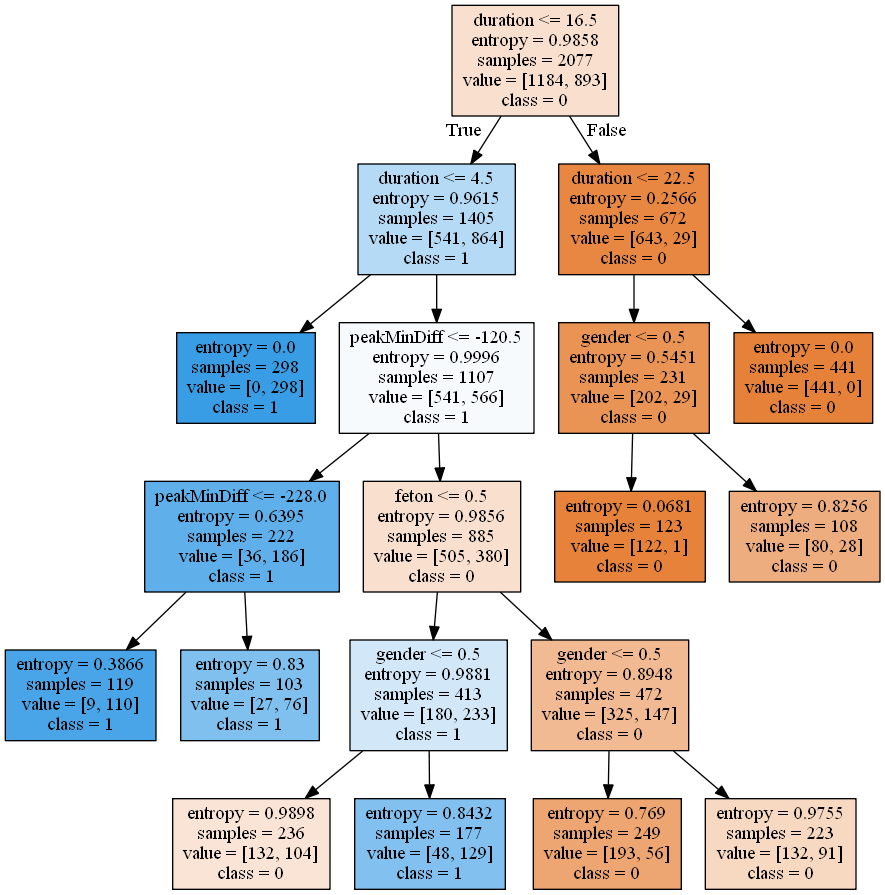

In [9]:
dot_data = tree.export_graphviz(
    clf, 
    out_file=None, 
    feature_names=train_data.columns,
    max_depth=5,
    class_names=['0','1'],
    filled=True
) 
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

cart预测

In [10]:
import sklearn.metrics as metrics

print(metrics.confusion_matrix(test_target, test_est, labels=[0, 1]))  # 混淆矩阵

[[491 254]
 [267 374]]


插入贝叶斯分布

In [11]:
#朴素贝叶斯
from sklearn.naive_bayes import BernoulliNB
#from sklearn.naive_bayes import GaussianNB      #MultinomialNB
NB = BernoulliNB(alpha=1)
NB.fit(train_data, train_target)
test_est = NB.predict(test_data)
print(metrics.classification_report(test_target, test_est))
NB.score(train_data, train_target)

             precision    recall  f1-score   support

        0.0       0.65      0.66      0.65       745
        1.0       0.60      0.58      0.59       641

avg / total       0.62      0.62      0.62      1386



0.64467982667308621

In [12]:
train_est = clf.predict(train_data)  # 用模型预测训练集的结果
train_est_p = clf.predict_proba(train_data)[:, 1]  # 用模型预测训练集的概率
test_est = clf.predict(test_data)  # 用模型预测测试集的结果
test_est_p = clf.predict_proba(test_data)[:, 1]  # 用模型预测测试集的概率

In [13]:
print(metrics.classification_report(test_target, test_est))  # 计算评估指标

             precision    recall  f1-score   support

        0.0       0.76      0.92      0.84       745
        1.0       0.88      0.67      0.76       641

avg / total       0.82      0.81      0.80      1386



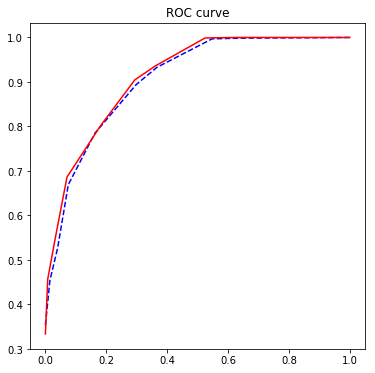

In [14]:
#绘制roc曲线
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')
plt.show()